In [18]:
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
%matplotlib inline
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 12, 8
import warnings
warnings.filterwarnings("ignore")

In [2]:
dataset = pd.read_csv("AirPassengers.csv")
dataset.head()

,Month,#Passengers
0,1949-01,112
1,1949-02,118
2,1949-03,132
3,1949-04,129
4,1949-05,121


In [3]:
# Convert string to DateTime format
dataset['Month'] = pd.to_datetime(dataset['Month'], infer_datetime_format=True)
indexedDataset = dataset.set_index(['Month'])

In [4]:
from datetime import datetime
indexedDataset.head()

,#Passengers
Month,
1949-01-01,112
1949-02-01,118
1949-03-01,132
1949-04-01,129
1949-05-01,121


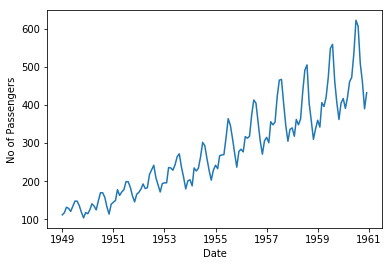

In [5]:
# plot graph

plt.xlabel("Date")
plt.ylabel("No of Passengers")
plt.plot(indexedDataset)

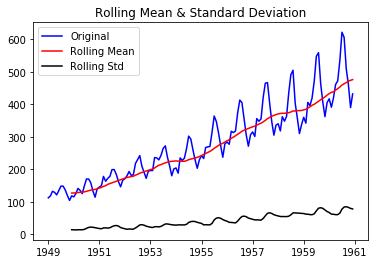

Results of Dickey-Fuller Test:
Test Statistic                   0.815369
p-value                          0.991880
#Lags Used                      13.000000
Number of Observations Used    130.000000
Critical Value (1%)             -3.481682
Critical Value (5%)             -2.884042
Critical Value (10%)            -2.578770
dtype: float64


In [6]:
from statsmodels.tsa.stattools import adfuller
def test_stationarity(timeseries):
    
    #Determing rolling statistics
    rolmean = timeseries.rolling(window = 12).mean()
    rolstd = timeseries.rolling(window = 12).std()

    #Plot rolling statistics:
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    
    #Perform Dickey-Fuller test:
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries['#Passengers'], autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)

test_stationarity(indexedDataset)

In [7]:
## Though the variation in standard deviation is small, mean is clearly increasing with time and this is not a stationary series.
## Also, the test statistic is way more than the critical values.

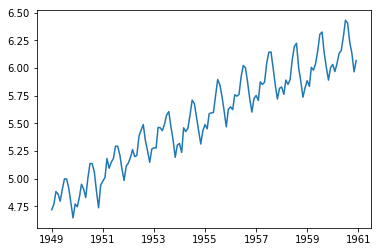

In [8]:
# Estimated trend
indexedDataset_log = np.log(indexedDataset)
plt.plot(indexedDataset_log)

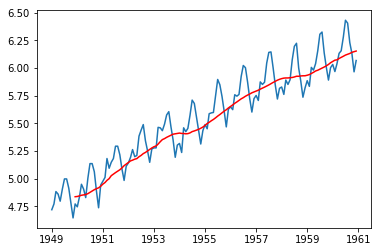

In [9]:
# calculating moving average for the log scale dataset
movingAverage = indexedDataset_log.rolling(window = 12).mean()
movingSTD = indexedDataset_log.rolling(window = 12).std()
plt.plot(indexedDataset_log)
plt.plot(movingAverage, color='red')

In [10]:
# minus moving average
indexedDataset_log_Minus_MovingAverage = indexedDataset_log - movingAverage
indexedDataset_log_Minus_MovingAverage.head(12)

,#Passengers
Month,
1949-01-01,NaN
1949-02-01,NaN
1949-03-01,NaN
1949-04-01,NaN
1949-05-01,NaN
1949-06-01,NaN
1949-07-01,NaN
1949-08-01,NaN
1949-09-01,NaN


In [11]:
# remove nan
indexedDataset_log_Minus_MovingAverage.dropna(inplace = True)
indexedDataset_log_Minus_MovingAverage.head(12)

,#Passengers
Month,
1949-12-01,-0.065494
1950-01-01,-0.093449
1950-02-01,-0.007566
1950-03-01,0.099416
1950-04-01,0.052142
1950-05-01,-0.027529
1950-06-01,0.139881
1950-07-01,0.260184
1950-08-01,0.248635


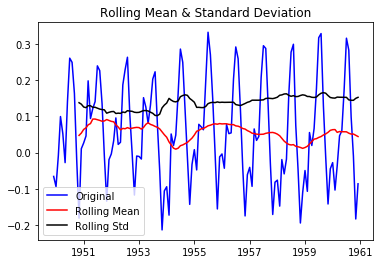

Results of Dickey-Fuller Test:
Test Statistic                  -3.162908
p-value                          0.022235
#Lags Used                      13.000000
Number of Observations Used    119.000000
Critical Value (1%)             -3.486535
Critical Value (5%)             -2.886151
Critical Value (10%)            -2.579896
dtype: float64


In [12]:
# again test for stationarity
test_stationarity(indexedDataset_log_Minus_MovingAverage)

## Test Statistic and Critical Value are almost equal ==> stationary

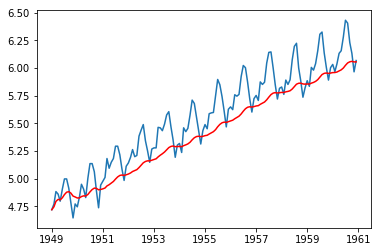

In [13]:
## exponentially weighted moving average where weights are assigned to all the previous values with a decay factor

exponentialDecayWeightedAverage = indexedDataset_log.ewm(halflife = 12, min_periods = 0, adjust = True).mean()
plt.plot(indexedDataset_log)
plt.plot(exponentialDecayWeightedAverage, color='red')

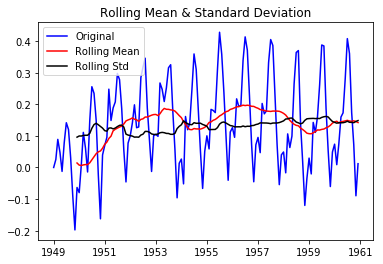

Results of Dickey-Fuller Test:
Test Statistic                  -3.601262
p-value                          0.005737
#Lags Used                      13.000000
Number of Observations Used    130.000000
Critical Value (1%)             -3.481682
Critical Value (5%)             -2.884042
Critical Value (10%)            -2.578770
dtype: float64


In [14]:
# minus the exponential decay average
indexedDataset_log_Minus_ExponentialDecayAverage = indexedDataset_log - exponentialDecayWeightedAverage
test_stationarity(indexedDataset_log_Minus_ExponentialDecayAverage)

In [15]:
## This TS has even lesser variations in mean and standard deviation in magnitude. 
##Also, the test statistic is smaller than the 1% critical value, which is better than the previous case

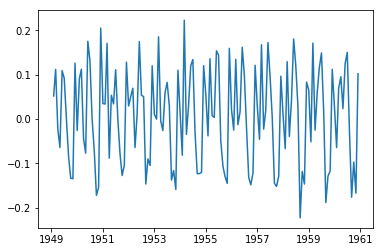

In [16]:
# Shifting the values to Time Series (shifted by value 1, so for ARIMA d = 1)
datasetLogDiffShifting = indexedDataset_log - indexedDataset_log.shift()
plt.plot(datasetLogDiffShifting)

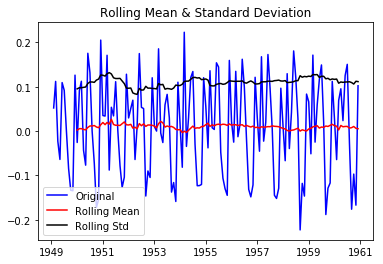

Results of Dickey-Fuller Test:
Test Statistic                  -2.717131
p-value                          0.071121
#Lags Used                      14.000000
Number of Observations Used    128.000000
Critical Value (1%)             -3.482501
Critical Value (5%)             -2.884398
Critical Value (10%)            -2.578960
dtype: float64


In [17]:
# dropping na values and testing for stationary
datasetLogDiffShifting.dropna(inplace=True)
test_stationarity(datasetLogDiffShifting)

In [19]:
# We can see that the mean and std variations have small variations with time. 
# Also, the Dickey-Fuller test statistic is less than the 10% critical value, thus the TS is stationary with 90% confidence

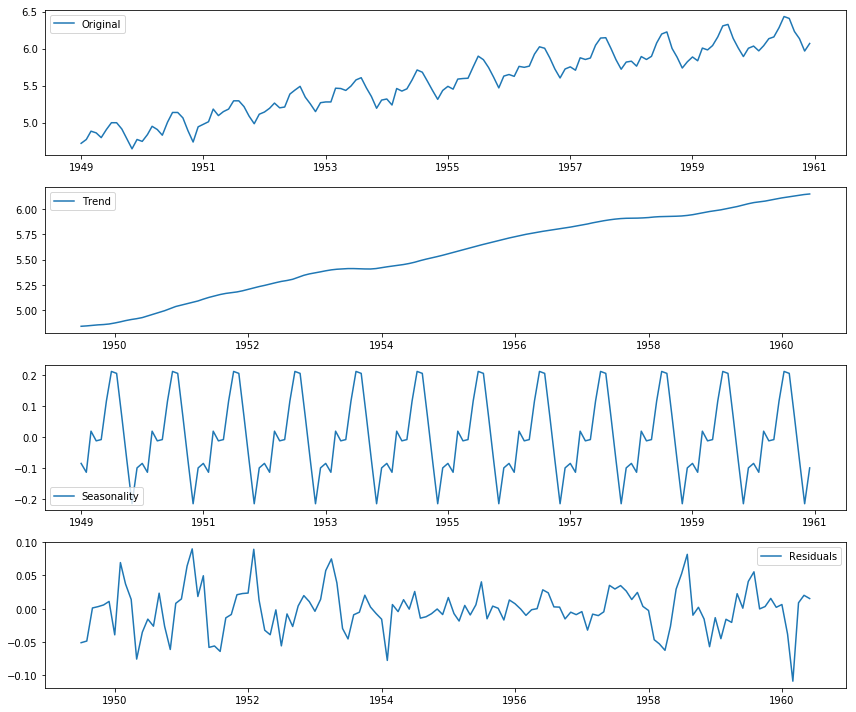

In [21]:
## Decomposing
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(indexedDataset_log)

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.subplot(411)
plt.plot(indexedDataset_log, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()

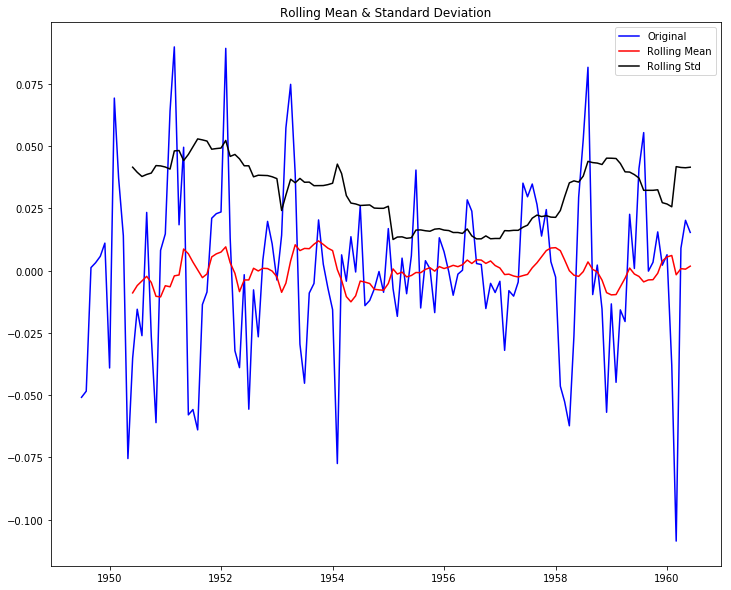

Results of Dickey-Fuller Test:
Test Statistic                -6.332387e+00
p-value                        2.885059e-08
#Lags Used                     9.000000e+00
Number of Observations Used    1.220000e+02
Critical Value (1%)           -3.485122e+00
Critical Value (5%)           -2.885538e+00
Critical Value (10%)          -2.579569e+00
dtype: float64


In [22]:
decomposedLog = residual
decomposedLog.dropna(inplace= True)
test_stationarity(decomposedLog)

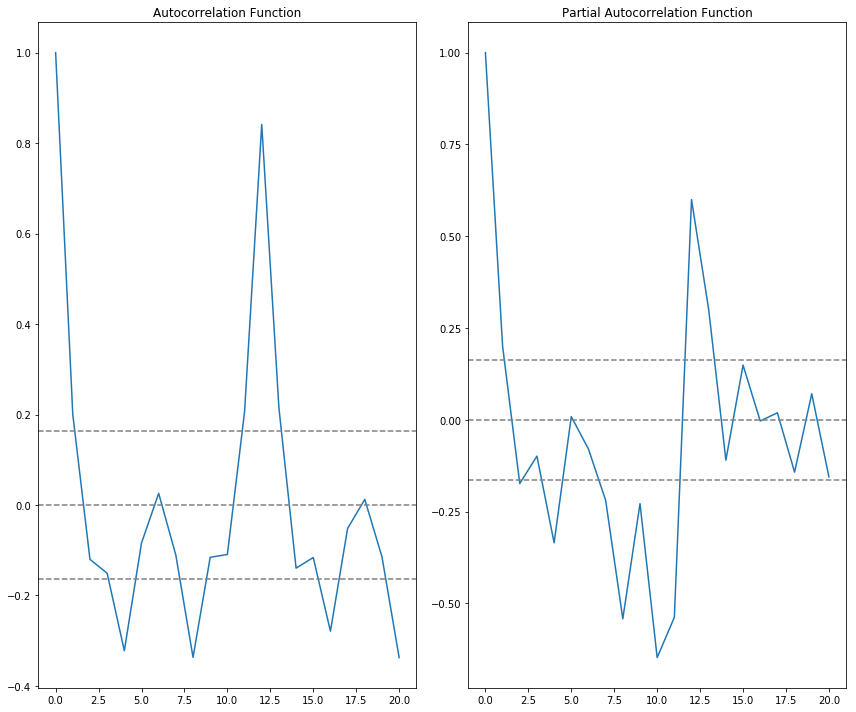

In [24]:
# Plot Autocorrelation Function (ACF) and Partial Autocorrelation Function (PACF) graphs for Q and P values in ARIMA

from statsmodels.tsa.stattools import acf, pacf

lag_acf = acf(datasetLogDiffShifting, nlags=20)
lag_pacf = pacf(datasetLogDiffShifting, nlags=20, method='ols')

#Plot ACF: 
plt.subplot(121) 
plt.plot(lag_acf)
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(datasetLogDiffShifting)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(datasetLogDiffShifting)),linestyle='--',color='gray')
plt.title('Autocorrelation Function')

#Plot PACF:
plt.subplot(122)
plt.plot(lag_pacf)
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(datasetLogDiffShifting)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(datasetLogDiffShifting)),linestyle='--',color='gray')
plt.title('Partial Autocorrelation Function')
plt.tight_layout()

In [25]:
## The lag value where the chart crosses the upper confidence interval for the first time. 
## By this we get P = 2 and Q = 2

Ploting AR Model


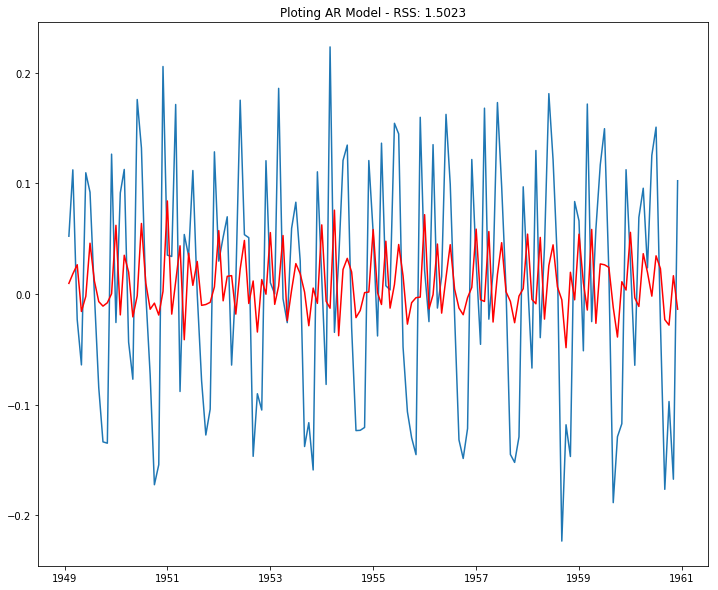

In [29]:
# ARIMA Model (p,d,q)

from statsmodels.tsa.arima_model import ARIMA

# AR Model

model = ARIMA(indexedDataset_log, order=(2, 1, 0))  
results_AR = model.fit(disp=-1)  
plt.plot(datasetLogDiffShifting)
plt.plot(results_AR.fittedvalues, color='red')
plt.title('AR Model - RSS: %.4f'% sum((results_AR.fittedvalues-datasetLogDiffShifting['#Passengers'])**2))

Text(0.5,1,'MA Model - RSS: 1.4721')

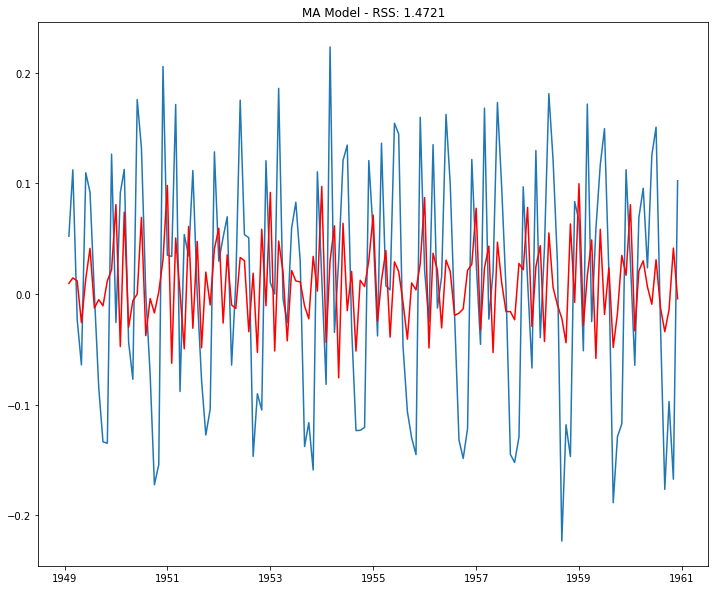

In [30]:
#MA Model

model = ARIMA(indexedDataset_log, order=(0, 1, 2))  
results_MA = model.fit(disp=-1)  
plt.plot(datasetLogDiffShifting)
plt.plot(results_MA.fittedvalues, color='red')
plt.title('MA Model - RSS: %.4f'% sum((results_MA.fittedvalues-datasetLogDiffShifting['#Passengers'])**2))

Text(0.5,1,'Combined Model - RSS: 1.0292')

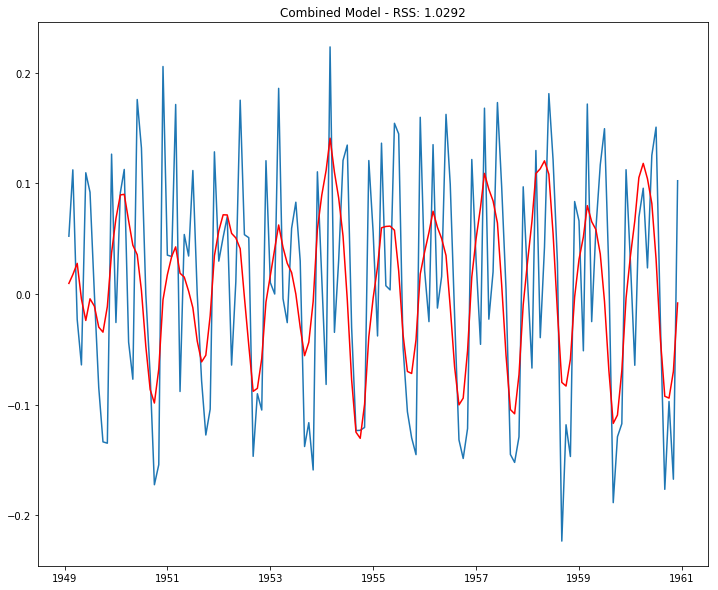

In [31]:
# Combined Model

model = ARIMA(indexedDataset_log, order=(2, 1, 2))  
results_ARIMA = model.fit(disp=-1)  
plt.plot(datasetLogDiffShifting)
plt.plot(results_ARIMA.fittedvalues, color='red')
plt.title('Combined Model - RSS: %.4f'% sum((results_ARIMA.fittedvalues-datasetLogDiffShifting['#Passengers'])**2))

In [32]:
## Here we can see that the AR and MA models have almost the same RSS but combined is significantly better. 

In [33]:
# Converting to Original Scale

predictions_ARIMA_diff = pd.Series(results_ARIMA.fittedvalues, copy=True)
predictions_ARIMA_diff.head()

Month
1949-02-01    0.009580
1949-03-01    0.017491
1949-04-01    0.027670
1949-05-01   -0.004521
1949-06-01   -0.023889
dtype: float64

In [34]:
# remove the lag '1' we have added 

predictions_ARIMA_diff_cumsum = predictions_ARIMA_diff.cumsum()
predictions_ARIMA_diff_cumsum.head()

Month
1949-02-01    0.009580
1949-03-01    0.027071
1949-04-01    0.054742
1949-05-01    0.050221
1949-06-01    0.026331
dtype: float64

In [37]:
#  add them to base number

predictions_ARIMA_log = pd.Series(indexedDataset_log['#Passengers'].iloc[0], index=indexedDataset_log.index)
predictions_ARIMA_log = predictions_ARIMA_log.add(predictions_ARIMA_diff_cumsum,fill_value=0)
predictions_ARIMA_log.head()

Month
1949-01-01    4.718499
1949-02-01    4.728079
1949-03-01    4.745570
1949-04-01    4.773241
1949-05-01    4.768720
dtype: float64

0.43193152675833957


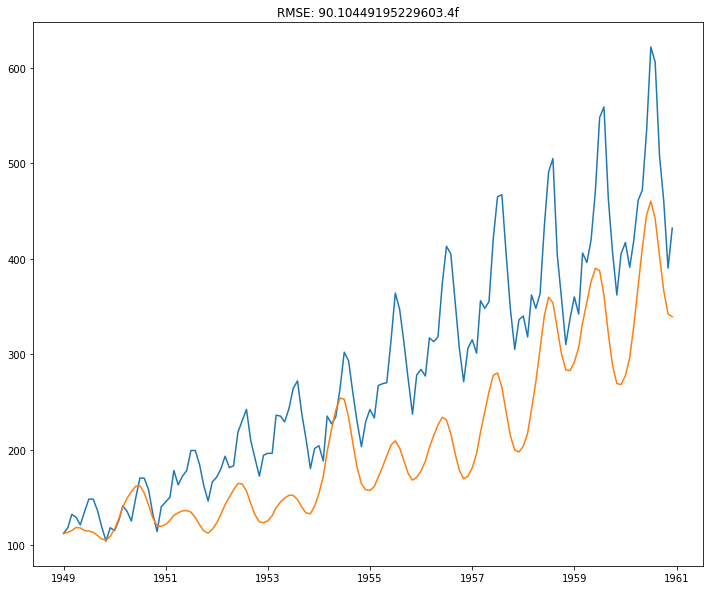

In [44]:
# Last step is to take the exponent and compare with the original series
from sklearn.metrics import mean_squared_error, r2_score

predictions_ARIMA = np.exp(predictions_ARIMA_log)

plt.plot(indexedDataset)
plt.plot(predictions_ARIMA)
plt.title('RMSE: {0}.4f'.format(np.sqrt(mean_squared_error(indexedDataset, predictions_ARIMA))))
print(r2_score(indexedDataset, predictions_ARIMA))

In [45]:
## We got RMSE value of 90
indexedDataset.shape

(144, 1)

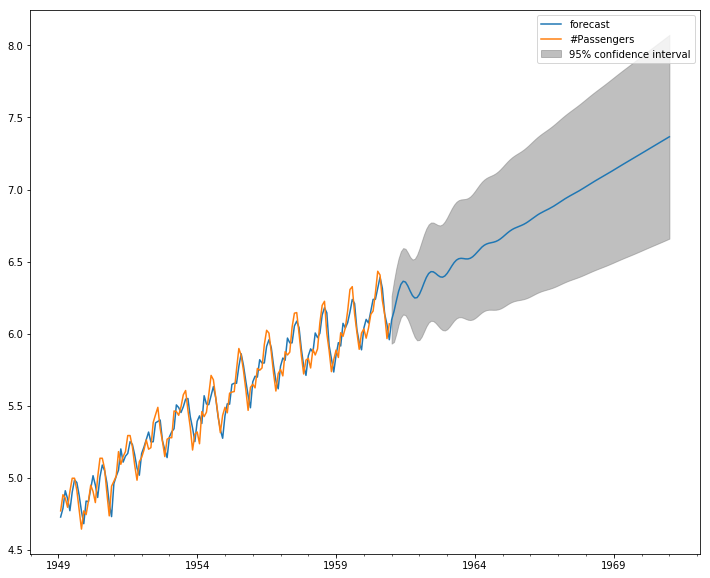

In [46]:
# To forecast next 10 years = 120 months. Then add 120 to 144 = 264

# plot the predictions
results_ARIMA.plot_predict(1,264)

# prediction values for 10 year
x = results_ARIMA.forecast(steps=120)